In [176]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 5

In [1]:
import time
import logging
import sys
import gzip

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as stats
from scipy.signal import savgol_filter

from collections import Counter

from scipy import stats
def r(x, y):
    return stats.pearsonr(x, y)[0]

%matplotlib inline

samples = ["data_2021-08-27/ky08", "data_2021-08-27/ky10", "data_2021-08-27/ky06", "data_2021-11-10/ky04", "data_2021-08-27/ky17", "data_2021-08-27/ky18", "data_2021-08-27/ky11", "data_2021-08-27/ky13"]

pd.set_option('display.max_colwidth', None)

In [2]:
#load in preprocessed mnetseq dfs
dfs = []

for i, x in enumerate(samples):
    df = pd.read_csv(x+'/'+x[-4:]+'_info.new.clean.gtf')
    print(i)
    dfs.append(df)

0
1
2
3
4
5
6
7


In [74]:
lorax_sigs = []

for i, x in enumerate(samples):
    df = pd.read_csv(x+'/hotspots.new.clean.gtf')
    print(i)
    lorax_sigs.append(df)

0
1
2
3
4
5
6
7


In [3]:
#clean data

keepme = ['protein_coding', '.']
clean_dfs = []

for df in dfs:
    print(len(df))
    
    reads_to_remove = df[~df['gene_type'].isin(keepme)]['read_id']
    cdf = df[~df.read_id.isin(reads_to_remove)]
    cdf = cdf.drop_duplicates('read_id')
    
    clean_dfs.append(cdf)

6888297
27990357
10827255
14633074
33457091
42318663
18140416
8786470


In [171]:
#find cross-correlation
allcorrs = []


for p1, p2 in ([0, 2], [3, 1], [6, 4], [7, 5]):

    df1 = clean_dfs[p1] 
    df2 = clean_dfs[p2] #fix the ko and shift wt
    print(len(df1))
    print(len(df2))

    genelens = df1[df1.gene_type == 'protein_coding'].drop_duplicates('gene_name')
    genelens = genelens[['gene_name', 'gene_start', 'gene_end', 'gene_strand']]

    df1 = df1[df1.gene_type == 'protein_coding'].groupby(['gene_name', '3prime']).size()
    df2 = df2[df2.gene_type == 'protein_coding'].groupby(['gene_name', '3prime']).size()

    df1 = df1 * 1E6 / df1.sum()
    df2 = df2 * 1E6 / df2.sum()

    genelens['gene_len'] = genelens.gene_end - genelens.gene_start

    #get rpkm table
    g = df1.groupby('gene_name').size().reset_index()
    g.iloc[:, 1] = (g.iloc[:, 1] * 1E6 / sum(g.iloc[:, 1]))
    g = g.merge(genelens, on='gene_name')
    g.iloc[:, 1] = g.iloc[:, 1] / (g.gene_len / 1000)

    g = g[~g.gene_name.str.contains('MT-')]
    g = g[g.gene_len > 60]

    filt = g.sort_values(0,ascending=False).gene_name[0:200]
    len(filt)

    xcorrsvs = []

    count = 0
    for gene in filt:
        #print(gene)
        if gene in df1 and gene in df2:

            a = df1[gene].reset_index()
            b = df2[gene].reset_index()

            genestart = genelens[genelens.gene_name == gene].gene_start.iloc[0]
            geneend = genelens[genelens.gene_name == gene].gene_end.iloc[0]
            genelen = geneend-genestart
            genestrand = genelens[genelens.gene_name == gene].gene_strand.iloc[0]


            #print(gene + ' ' + str(count))
            count += 1

            filled = pd.DataFrame(range(genestart, geneend), columns=['3prime']).merge(a, on='3prime', how='outer').merge(b, on='3prime', how='outer').fillna(0)

            #run xcorr loop

            arr1 = filled['0_x']
            arr2 = filled['0_y'][30:-31]

            xcorr = []
            for i in range(30, -31, -1):
                xcorr.append(r(arr1[30+i:-31+i], arr2))

            if genestrand == '-':
                xcorr.reverse()
            xcorrsvs.append(np.array(xcorr))

    allcorrs.append(np.nanmean(xcorrsvs,axis=0))

3690214
6274283
8538021
15719468
12315286
24103950
6427014
31091610


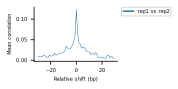

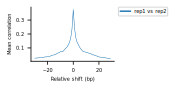

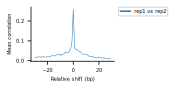

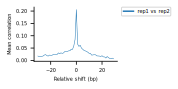

In [177]:
for i, a in enumerate(allcorrs):
    plt.figure(figsize = (1.5, 1))

    pdf = pd.DataFrame(zip(range(-30, 30), a), columns = ['shift', 'rep1 vs rep2'])
    ax = sns.lineplot(data=pdf.melt('shift'), x='shift', y='value', hue='variable', lw=.5)

    sns.despine()

    ax.set_xlabel('Relative shift (bp)')
    ax.set_ylabel('Mean correlation')
    #ax.set_ylim(0, .4)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.savefig('svg/rep_corr'+str(i)+'.svg', format="svg", dpi=1000)
    plt.show()

In [ ]:
plt.figure(figsize = (1.5, 1))

pdf = pd.DataFrame(zip(range(-30, 30), np.nanmean(xcorrsvs,axis=0)), columns = ['shift', 'rep1 vs rep2'])
ax = sns.lineplot(data=pdf.melt('shift'), x='shift', y='value', hue='variable', lw=.5)

sns.despine()

ax.set_xlabel('Relative shift (bp)')
ax.set_ylabel('Mean correlation')
#ax.set_ylim(0, .4)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig('svg/lorax_corr.svg', format="svg", dpi=1000)
plt.show()

lines.append(np.nanmean(xcorrsvs,axis=0)))

In [178]:
lens = clean_dfs[0].drop_duplicates('gene_name').copy()
lens['gene_len'] = lens['gene_end'] - lens['gene_start']

lens = lens.loc[:,['gene_name', 'gene_len', 'gene_type']]

In [193]:
leg = ['wt lorax 1', 'ko lorax 1', 'wt lorax 2', 'ko lorax 2', 'wt net 1', 'ko net 1', 'wt net 2', 'ko net 2']

In [194]:
genenames = []

for i, df in enumerate(clean_dfs):
    
    df = df[df.read_strand_1 == df.gene_strand]
    g = df.groupby('gene_name').size().reset_index()
    g.iloc[:, 1] = (g.iloc[:, 1] * 1E6 / sum(g.iloc[:, 1]))
    
    
    g = g.merge(lens, on='gene_name')
    
    g.iloc[:, 1] = g.iloc[:, 1] / (g.gene_len / 1000)
    
    g = g.rename(columns={0: leg[i]})
    
    g = g.iloc[:, 0:2]
    genenames.append(g)

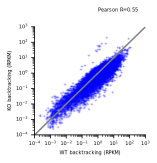

In [198]:
g = genenames[5]
g = g.merge(genenames[7])

g = g[g.gene_name != '.']


plt.figure(figsize = (2, 2))

ax = sns.scatterplot(x=g.columns[1], y=g.columns[2], data=g, s=3, linewidth=0, alpha=.5, color='blue', rasterized=True)
sns.lineplot(x=[-1E1, 1E5], y=[-1E1, 1E5], ax=ax, color='gray')

plt.text(1, 1E4, 'Pearson R={:.2f}'.format(r(g.iloc[:, 1], g.iloc[:, 2])))

sns.despine()

ax.set_xlabel('WT backtracking (RPKM)')
ax.set_ylabel('KO backtracking (RPKM)')
ax.set_xlim(1E-4, 1E3)
ax.set_ylim(1E-4, 1E3)
ax.set_yscale('log')
ax.set_xscale('log')
#ax.tick_params(which="minor")


plt.savefig('svg/rep_corr_bygene.svg', format="svg", dpi=1000)
plt.show()